In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
from scipy.stats import skew, kurtosis
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Problem 1

<i>Sentinel-2 provides multispectral data across the visible, near-infrared (NIR), and shortwave-
infrared (SWIR) regions. These bands come with different spatial ground sampling distances
(GSD): 10 meters for B2 (Blue), B3 (Green), B4 (Red), and B8 (NIR), 20 meters for several
red-edge and SWIR bands, and 60 meters for atmospheric correction bands; we will delve
more into remote sensing aspect of things in the week 5. For consistency and analysis, all
bands have been resampled to 30 meters. The provided dataset is surface reflectance.</i>

1. <i>Plot each of the 12 Sentinel-2 bands separately, ensuring that you identify what each
band corresponds to in terms of its wavelength. Use a vibrant colormap, like cmcocean
library. </i>

2. <i>What is your approach to a proper visualization in terms of stretching (implement
this in your visualization)? </i>

3. <i>You can see part of the image is considered no data, how would
you go about that? (you will use this in the following problems as well)</i>

<i>None = plot_band(args)</i>

## Problem 1 Answer

Begin by loading in the Sentinel-2 Daata for Rochester, NY and checking data shape: 

In [56]:
## Load in Sentinel-2
data = np.load('sentinel2_rochester.npy')
data.shape


(954, 716, 12)

For future plotting in this assigment, I created two lists of band names, one with their central wavelengths and one with just their short names. Per the notes at the end of the assigment, Band 10 is excluded.

In [57]:
# Create a list of titles for each band -- Band 10 is excluded
band_names = ['Band 1 - Coastal aerosol, 443nm',
               'Band 2 - Blue, 490nm',
               'Band 3 - Green, 560nm',
               'Band 4 - Red, 665nm',
               'Band 5 - Vegetation Red Edge, 705nm',
               'Band 6 - Vegetation Red Edge, 740nm',
               'Band 7 - Vegetation Red Edge, 783nm',
               'Band 8 - NIR, 842nm',
               'Band 8A - Narrow NIR, 865nm',
               'Band 9 - Water vapor, 945nm',
               'Band 11 - SWIR, 1610nm',
               'Band 12 - SWIR, 2190nm'] 

band_short_names = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']

The function below stretches the 98th percentile and 2nd percentile values in the bands, and stretches them so that they are 1 and 0 respectively, and helps provide more contrast in the image.

In [58]:
#Helper function to deal with stretch
def stretch(data, lower_percent=2, upper_percent=98):
    #Create an array to hold the stretched values
    stretched = np.zeros_like(data, dtype=float)
    for i in range(data.shape[2]): 
        band = data[:, :, i] 
        #Finds the highest and lowest values in the band 
        p_low, p_high = np.nanpercentile(band, [lower_percent, upper_percent])
        #Stretches values so that the highest values are 1, lowest are 0, allowing us to see more contrast
        stretched[:, :, i] = np.clip((band - p_low) / (p_high - p_low + 1e-10), 0, 1)
    return stretched

The function below plots each of the 12 bands separately using Matplotlib and uses the cmocean.cm.matter library to give vibrant coloring to the maps, without using a colorway that could be miscontrued for something else, like the algae colorway. 

Part of the image has no data when you plot them. These can be found by determining what reflectance data is zero for all 12 bands (as it is reflectance data, values should be between 0 and 1, and therefore a value of zero likely represents no data).

In [59]:
def plot_bands(data, plot_titles):
    # Create a mask for all-zero pixels and set them to NaN
    #Because it is reflectance data, values should be between 0 and 1. 0 likely indicates no data.
    mask = np.all(data == 0, axis=2)
    data[mask] = np.nan

    #Stretch the data
    stretched = stretch(data)
    #Get number of bands
    num_bands = data.shape[2]
    fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(16, 16))
    # Loop through each band and plot it
    for i in range(num_bands):
        band = stretched[:,:,i]
        # Display the plot for each band
        ax[i//2, i%2].imshow(band, cmap=cmocean.cm.matter)
        ax[i//2, i%2].set_title(plot_titles[i])
        ax[i//2, i%2].set_axis_off()
    plt.tight_layout()
    plt.show()

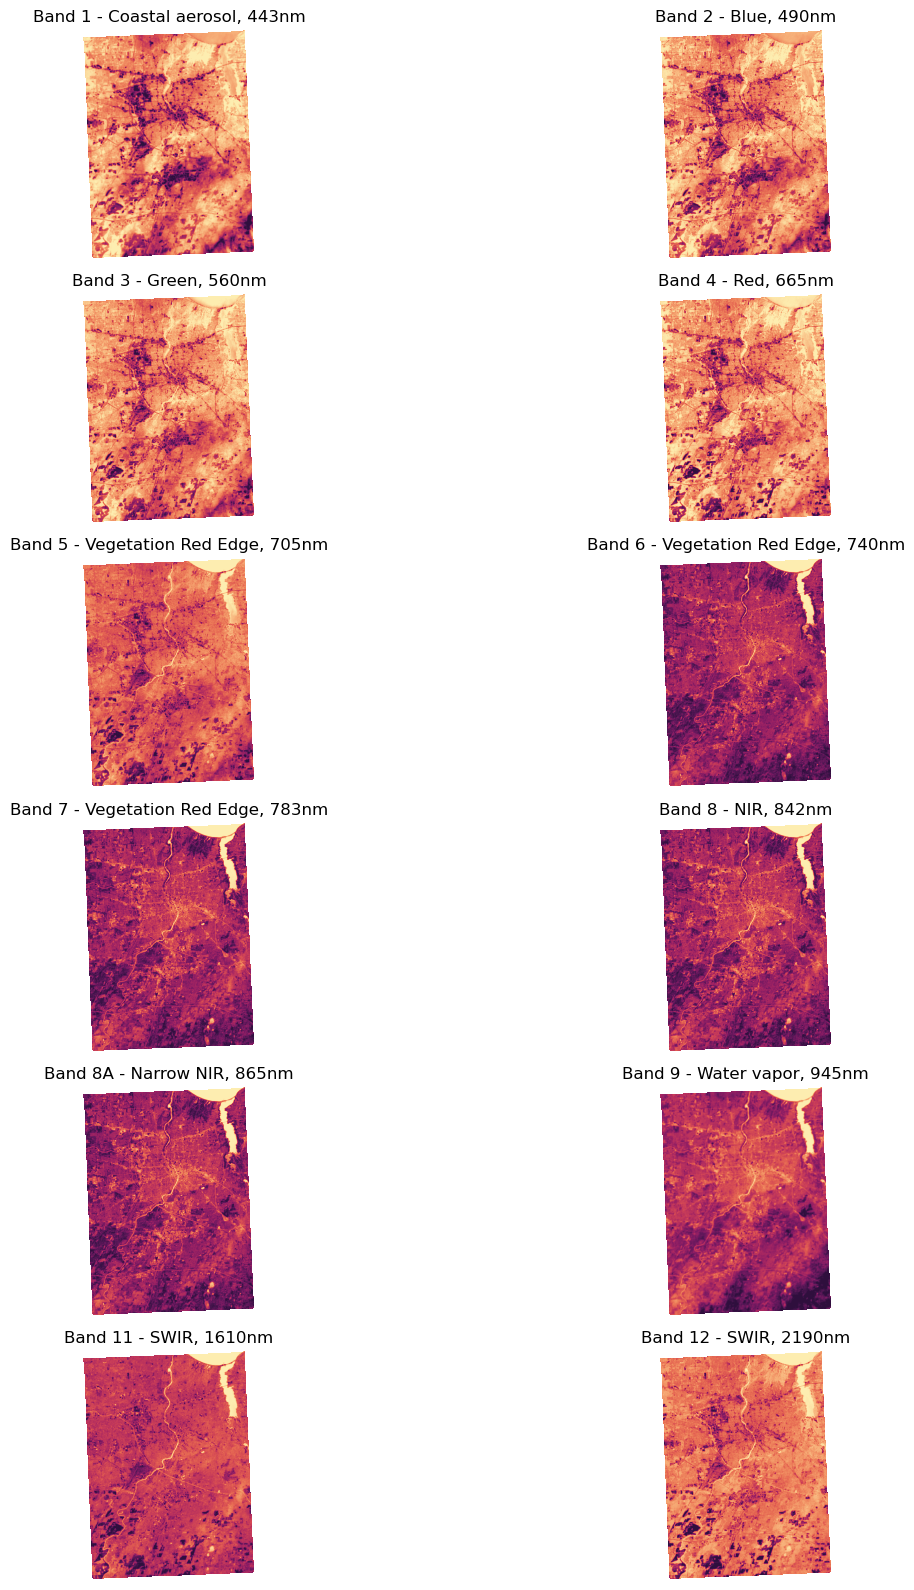

In [60]:
#Run the plotting function
plot_bands(data, band_names)

# Problem 2 (a) 
<i>Given the multi-spectral data for each band, define the function below that takes each band (treated as an independent random variable) and calculates the following statistics:
mean, standard deviation (std), minimum, maximum, quartiles (Q1, median, Q3), as well as skewness and kurtosis which was not covered in class. Explain what each of the statistics explain. Provide the statistics for all bands and all statistics as a table.</i>

<i>stats = calculate_band_statistics(args)</i>


## Problem 2(a) Answer

The function below calculates each of the following statistics for each of the bands:

- Mean: or the average, is the sum of all values divided by the number of values. It's a meaure of central tendency.
- Standard deviation (std): a measure of the amount of variation of the values of a variable about its mean. A lower std is closer to the mean, a higher one is further away.
- Quartiles: Fivide the data into four equal parts. Q1 is the 25th percentile, median is the 50th percentile, and Q3 is the 75th percentile. The 0th percentile (min) is the smallest value, and the 100th percentile (max) is the largest value.
- Skewness: a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. In a unimodal distribution like this data, a positive skewness value indicates values are more concentrated on the left side of the distribution A negative skewness value indicates values are more concentrated on the right side of the distribution.
- Kurtosis: a measure of the tailedness of a distribution. Tailedness is how often outliers occur.

Similar to the exercise above, this function determines which pixels have no data and sets them to NaN. This allows them to be excluded from the statistic calculations easily.        

In [61]:
def calculate_band_statistics(data, band_names):
    num_bands = data.shape[2]
    band_stats = []
    # Determine pixels for which all bands are zero, and set those pixels to NaN
    mask = np.all(data == 0, axis=2)
    data[mask] = np.nan

    #Calculate statistics for each band
    for i in range(num_bands):
        band = data[:,:,i]
        band = band.flatten()
        # Calculate basic statistics -- exclude NaN values in calculations, excludes no data values which were turned in the NaNs above
        # Mean, or the average, is the sum of all values divided by the number of values. It's a meaure of central tendency.
        mean = np.nanmean(band)
        #Standard deviation (std) is a measure of the amount of variation of the values of a variable about its mean. A lower std is closer to the mean, a higher one is further away.
        std = np.nanstd(band)
        # Quartiles divide the data into four equal parts. Q1 is the 25th percentile, median is the 50th percentile, and Q3 is the 75th percentile.
        #The 0th percentile (min) is the smallest value, and the 100th percentile (max) is the largest value.
        min_val = np.nanmin(band)
        max_val = np.nanmax(band)
        q1 = np.nanpercentile(band, 25)
        median = np.nanpercentile(band, 50)
        q3 = np.nanpercentile(band, 75)
        #Skewness is the a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. In a unimodal distribution like this data, a positive skewness value indicates values are more concentrated on the left side of the distribution A negative skewness value indicates values are more concentrated on the right side of the distribution.
        skewness = skew(band, nan_policy='omit', axis=None)
        #Kurtosis is a measure of the tailedness of a distribution. Tailedness is how often outliers occur.
        kurt = kurtosis(band, nan_policy='omit', axis=None)
        # Append the statistics for the current band to the list
        band_stats.append({
            'band': band_names[i],
            'mean': mean,
            'std': std,
            'min': min_val,
            'max': max_val,
            'q1': q1,
            'median': median,
            'q3': q3,
            'skewness': skewness,
            'kurtosis': kurt
        })
    # Convert the list of dictionaries to a pandas DataFrame to create a table
    return pd.DataFrame(band_stats)

In [62]:
#Calculate and display the statistics table
stats = calculate_band_statistics(data, band_names)
print(stats.to_markdown())

|    | band                                |      mean |       std |    min |    max |     q1 |   median |     q3 |   skewness |   kurtosis |
|---:|:------------------------------------|----------:|----------:|-------:|-------:|-------:|---------:|-------:|-----------:|-----------:|
|  0 | Band 1 - Coastal aerosol, 443nm     | 0.0886817 | 0.0279138 | 0.0333 | 0.6021 | 0.0709 |   0.0829 | 0.1007 |   2.92051  |   23.7974  |
|  1 | Band 2 - Blue, 490nm                | 0.0925416 | 0.0350015 | 0.0386 | 0.7542 | 0.0716 |   0.0853 | 0.1053 |   4.4789   |   43.108   |
|  2 | Band 3 - Green, 560nm               | 0.105496  | 0.0343652 | 0.043  | 0.7484 | 0.0858 |   0.0987 | 0.1168 |   4.69224  |   46.2931  |
|  3 | Band 4 - Red, 665nm                 | 0.0943111 | 0.0444543 | 0.0326 | 0.7728 | 0.0663 |   0.085  | 0.1093 |   3.23144  |   23.4076  |
|  4 | Band 5 - Vegetation Red Edge, 705nm | 0.136721  | 0.0409055 | 0.0346 | 0.8159 | 0.1152 |   0.131  | 0.1506 |   3.10802  |   27.3514  |
|  5 |

# Problem 2 (b)

<i>Define another function called to standardize the data for each band. This function should compute the z-scores for all pixel values in the band. Explain what standardization does to your data. Plot the histogram for each band’s original data and use the standardize data to highlight the outliers. This approach helps to better understand the distribution of
the data and identify any anomalies present.</i>

<i>data_standard = standardize(data)</i>

## Problem 2(b) Answer
Similar to the exercise above, this function determines which pixels have no data and sets them to NaN. This allows them to be excluded from the statistic calculations easily.

To calculate Z scores for each band, I took the value of each pixel in the band minus the mean, and divided it by the standard deviation. This standarization centers the mean, and sets the standard deviation of the new distribution to 1. It also helps determines outliers in the data set, as a datapoint with a Z score of above/below ±3 is usually considered an outlier.

This function then plots the original data distribution on the left, and then the standardized data on the right, with red lines indicating the ±3 z-scores.


In [63]:
def standardize(data, plot_titles):
    #Calculate number of bands to know how many times to loop
    num_bands = data.shape[2]

    # Like in previous exercises, determine pixels for which all bands are zero, and set those pixels to NaN
    mask = np.all(data == 0, axis=2)
    data[mask] = np.nan

    #Set up plots
    fig, ax = plt.subplots(nrows=12, ncols=2, figsize=(16, 30))
    
    #Create an array to store the z-scores
    standardized_data = np.full(data.shape, np.nan)

    #Calculate z-scores for all pixel values in each band
    #Z = (X - mu) / sigma
    for i in range(num_bands):
        band = data[:,:,i]
        #Calculate z-scores using formula Z = (X - mu) / sigma
        mean = np.nanmean(band)
        stdev = np.nanstd(band)
        z_scores = (band - mean) / stdev
        standardized_data[:,:,i] = z_scores
        #Plot histograms of original data and z-scores
        ax[i, 0].hist(band.flatten(), bins=100, alpha=.9,color='blue', label='Original Data')
        ax[i, 0].set_xlabel("Reflectance Value")
        ax[i, 0].set_ylabel("Frequency")
        ax[i, 0].set_title("Original Data Distribution" + " - " + plot_titles[i])
        ax[i, 1].hist(z_scores.flatten(), bins=100, alpha=.9,color='purple', label='Standardized Data')
        ax[i, 1].set_title("Standardized Data Distribution" + " - " + plot_titles[i])
        ax[i, 1].axvline(3, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold (|z|=3)')
        ax[i, 1].axvline(-3, color='red', linestyle='dashed', linewidth=2)
        ax[i, 1].set_xlabel("Z-score")
        ax[i, 1].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    return standardized_data



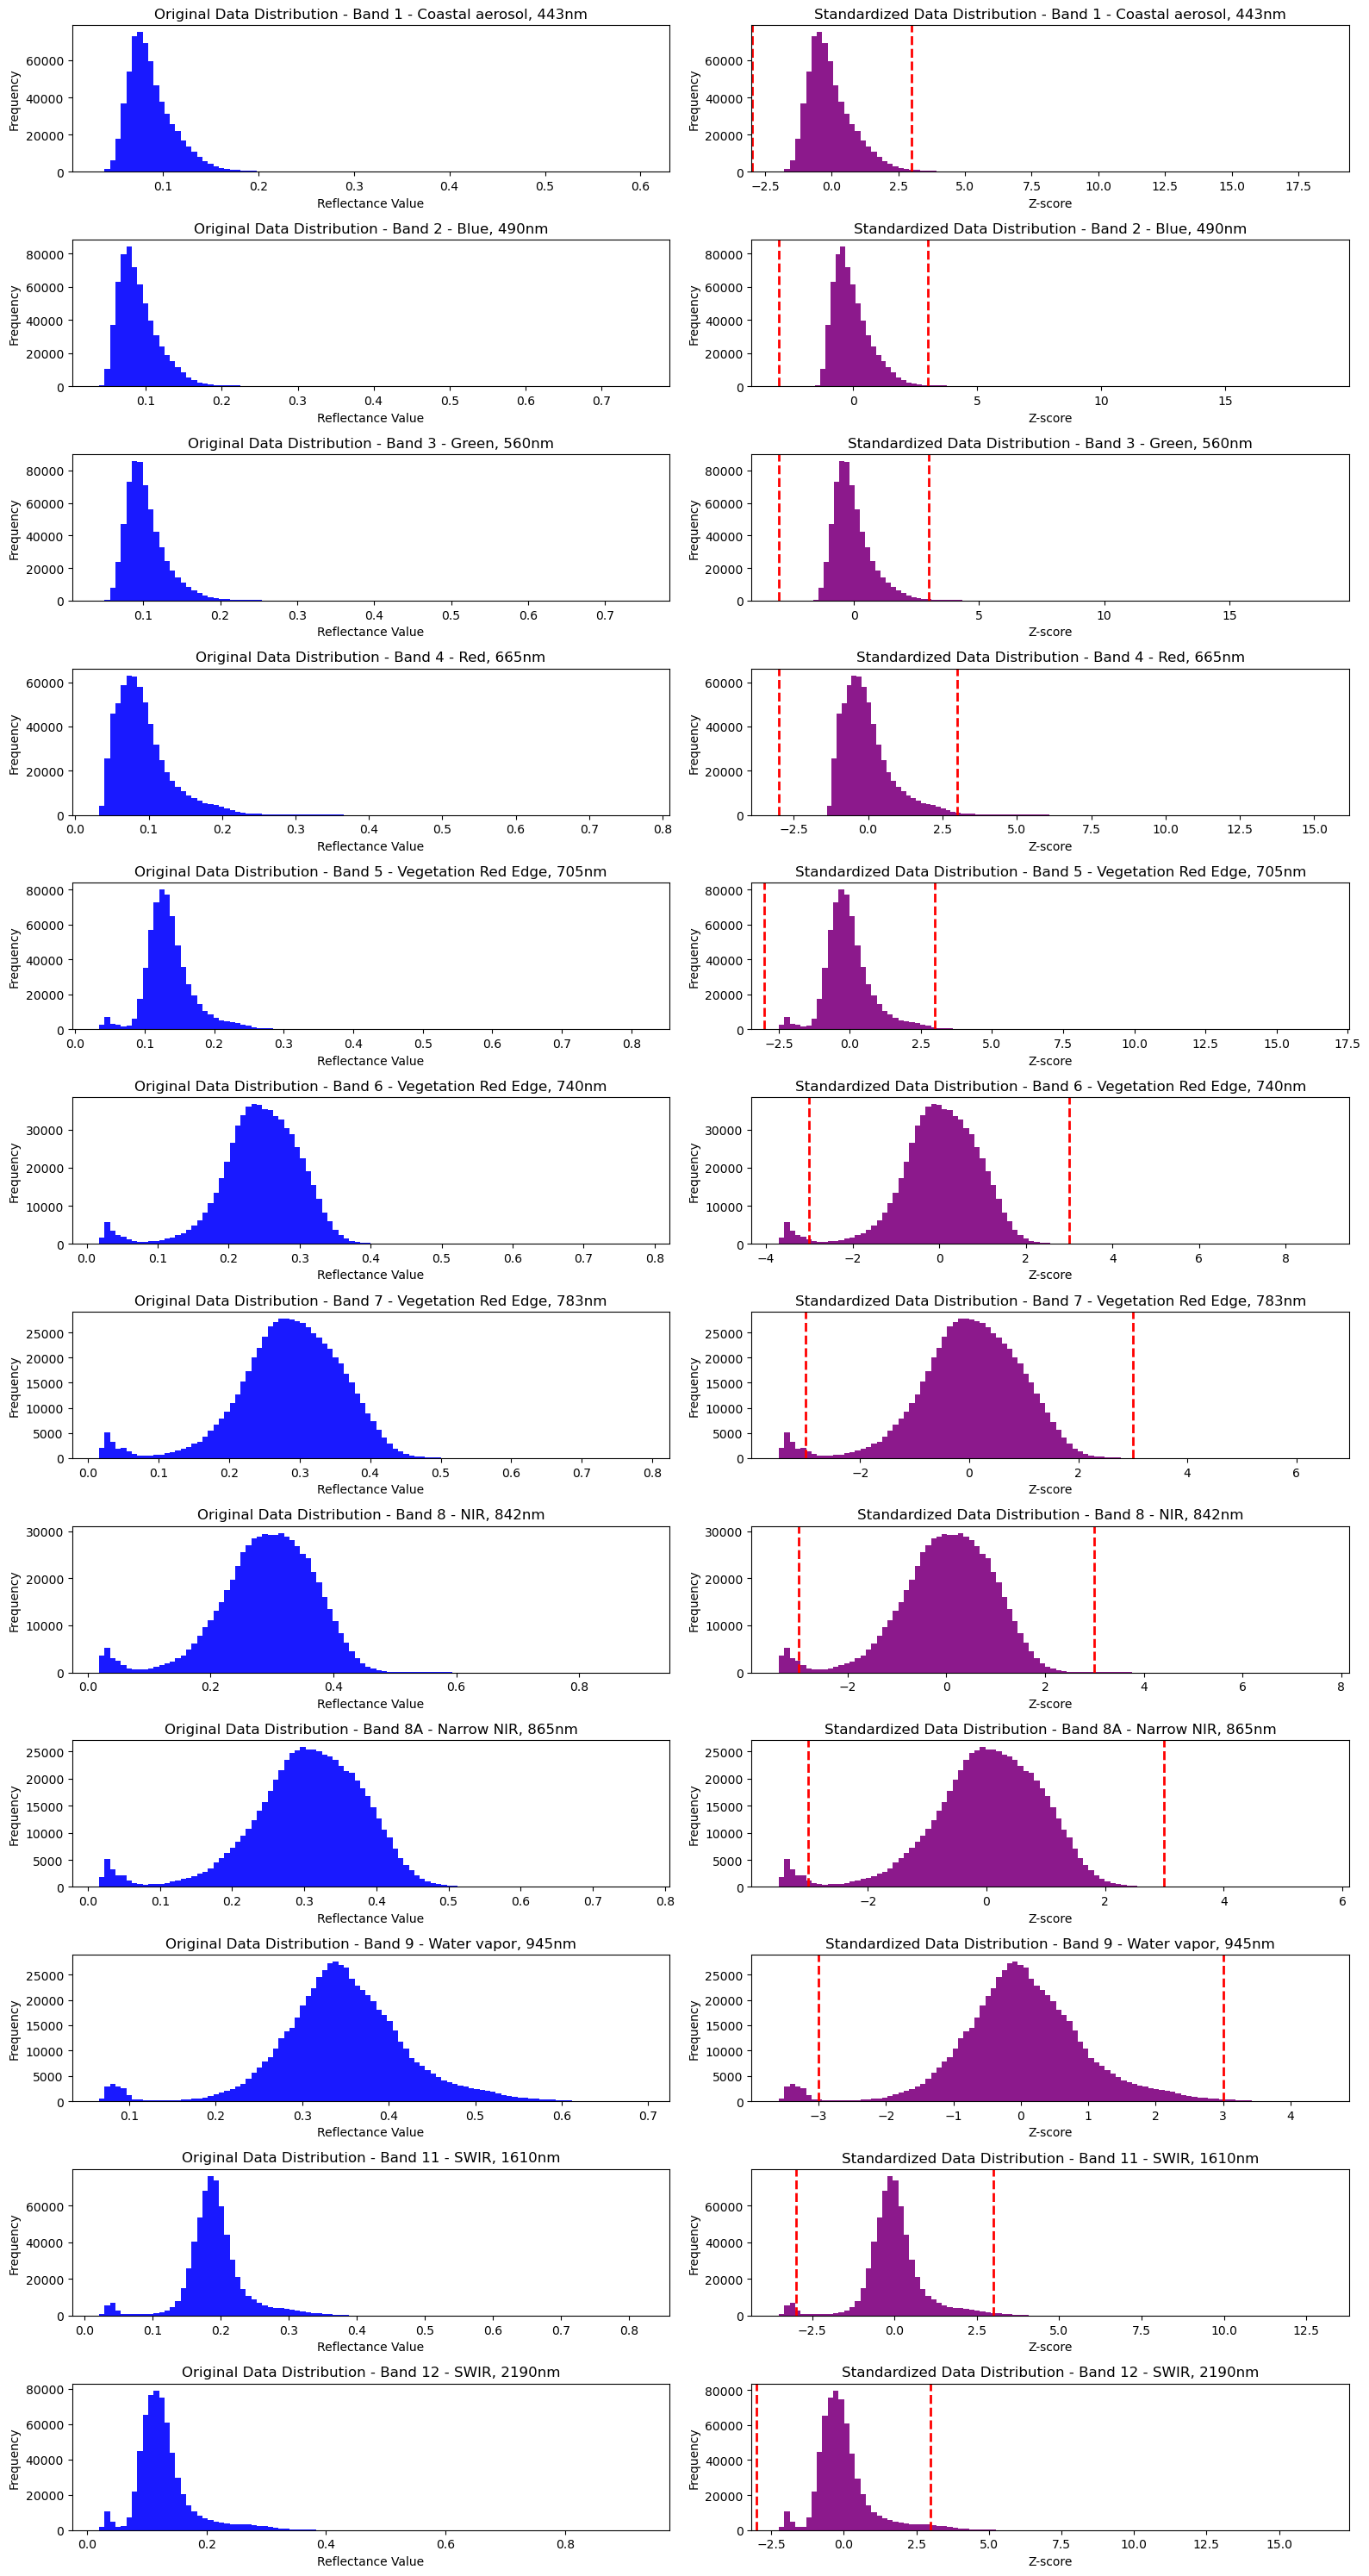

In [64]:
data_standard = standardize(data, band_names)

# Problem 3(a) 
<i>We aim to explore the relationships between variables in the multispectral data. First,
use the concept of the Pearson r correlation coefficient, as discussed in class, to compute the
correlation matrix for all bands. Plot this matrix as an image, where each cell represents
the correlation between two bands. What type of matrix is this? Analyze the relationships
between variables and describe what the correlation coefficients reveal about their linear
relationships.

corr_matrix = correlation_matrix(args)</i>

## Problem 3(a) Answer
The below function first takes the Sentinenal-2 data and converts it into a pandas dataframe with each column being the reflectance values for each band. it then uses corr() to find the pairwise correlation of all columns, creating a correlation matrix.

It then uses the Seaborn library to create a heatmap where each cell represents the correlation between two bands. 

In the chart created, the lighter the color, the more correlated they are. Most with strong correlation have a strong positive correlation. This means that thwe two bands have a close linear relationship where they tend to increase together. B1 - B5 all have a fairly strong positive correlation with each other, as do bands B6-B9, and then bands B10 and B11. This makes sense, as the bands are similar to each other in each grouping.

In [65]:
def correlation_matrix(data, labels):
        #Get number of bands to know how many times to loop
        num_bands = data.shape[2]
        df = pd.DataFrame()
        #Create a Pandas Dataframe with each column being the reflectance values for each band so that corr() can be used.
        for i in range(num_bands):
                band = data[:,:,i]
                df[labels[i]] = band.flatten()
        #Don't need to exclude NaN values here, corr() does it automatically.
        correlation_mat = df.corr()
        #Use Seaborn Library to generate heatmap, round values to 2 decimal places for readability
        sns.heatmap(round(correlation_mat,2), annot = True)
        plt.tight_layout()
        plt.show()
        return correlation_mat

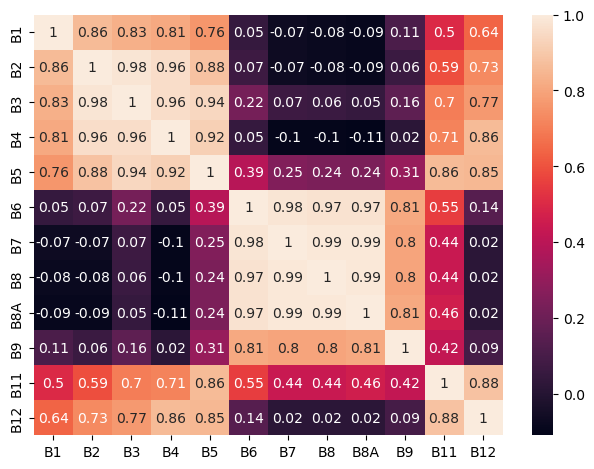

In [66]:
corr_matrix = correlation_matrix(data, band_short_names)

# Problem 3(b) 

<i>For the 10-meter bands (B2, B3, B4, and B8), define a function that creates two subplots:
the first displaying a pairwise scatter plot between every two vectors, and the second showing
the density of scatter plot points in the scatter plot. The density plot is particularly useful for
visualizing areas where data points are more concentrated (there is more than one technique
to this; pick your favorite). Analyze the observed patterns and describe any significant trends
or clusters in the data.</i>

<i>corr_matrix = correlation_plot(args)</i>

## Problem 3(b) Answer
The following function, like the function correlation_matrix(), first converts the bands of data to a Pandas Dataframe where each band is a column. It then removes the columns that are not 10-meter bands. 

I've then plotted a pairwise scatterplot and a pairwise density plot. Because the density plot was taking a while to load using the large dataset, I've taken a sample of 10,000 pixels.

Bands 2, 3 and 4 each have a strong positive linear correlation, as was noted above as well. 

In [67]:
def correlation_plot(data, band_short_names):
        # Like in previous exercises, determine pixels for which all bands are zero, and set those pixels to NaN
        mask = np.all(data == 0, axis=2)
        data[mask] = np.nan
        #Get number of bands to determine how many times to loop
        num_bands = data.shape[2]
        #Create dataframe for ea sier plotting
        df = pd.DataFrame()
        for i in range(num_bands):
                band = data[:,:,i]
                df[band_short_names[i]] = band.flatten()
        #Get only 10 meter bands
        ten_meter_bands = ['B2','B3','B4','B8']
        df = df[ten_meter_bands] #Plot only 10 meter bands
        g = sns.pairplot(df, kind='scatter')
        g.fig.suptitle("Pairwise Scatter Plots 10-Meter Bands", y=1.02)


        #Density Plot is taking a while to load, so get just a sample
        df_sample = df.sample(n=10000, random_state=42)
        #Plot Density of Each Combination
        h = sns.pairplot(df_sample, kind='kde')
        h.fig.suptitle("Density Plots 10-Meter Bands", y=1.02)
        

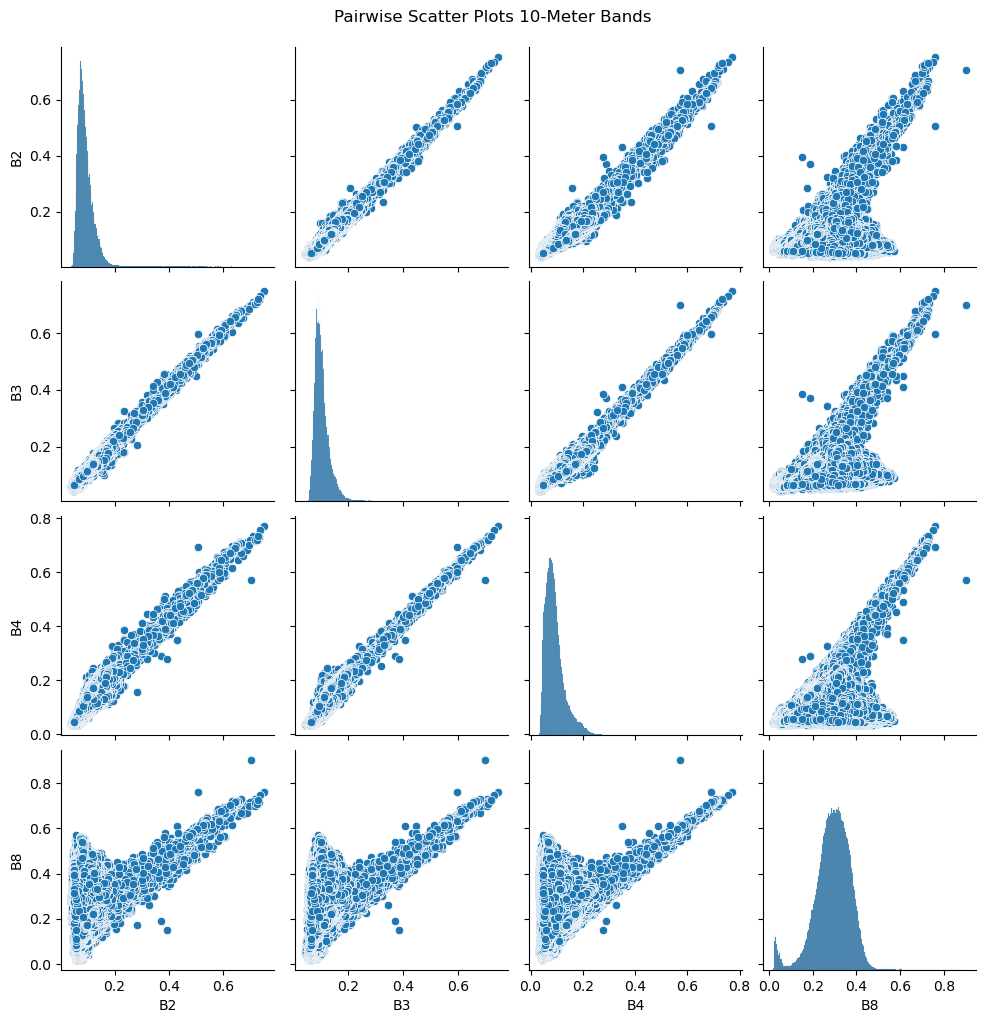

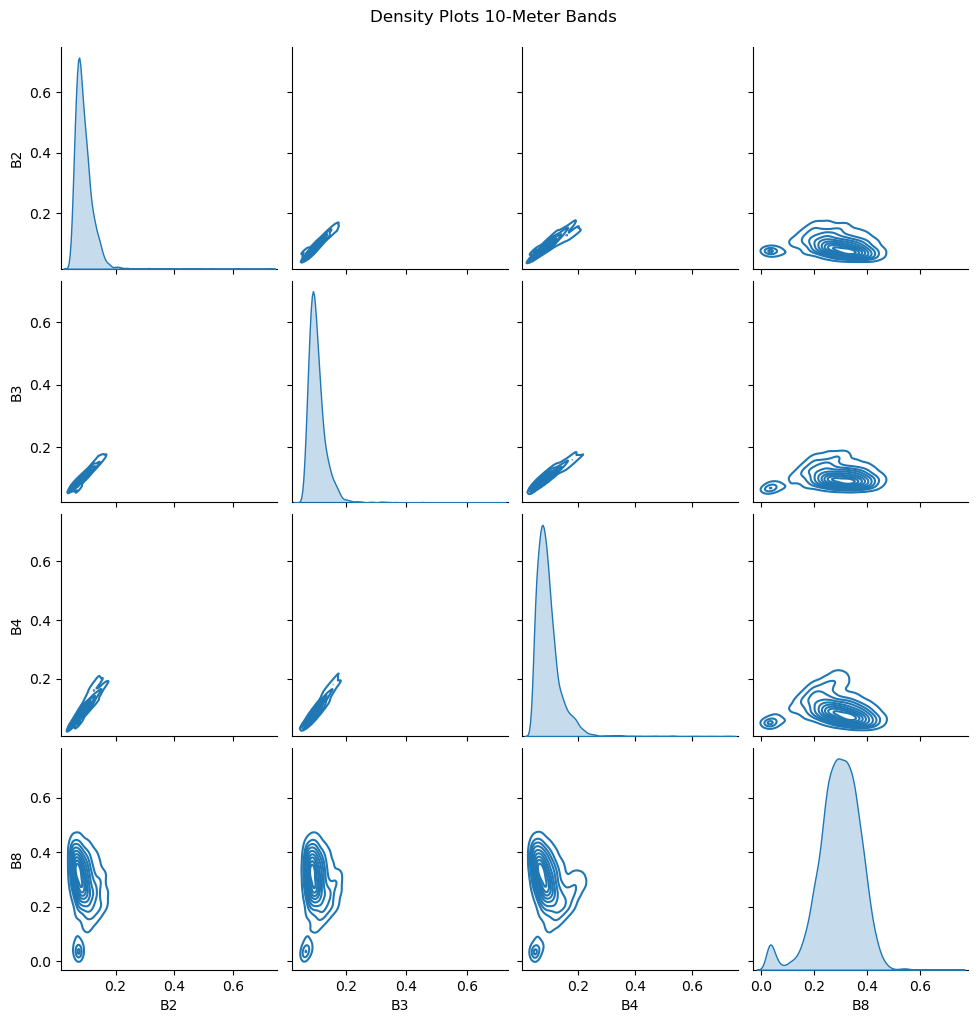

In [68]:
corr_matrix = correlation_plot(data, band_short_names)

# Problem 4

<i>Visit JPL Spectral Library. ECOSTRESS data provides high-resolution lab-based spectral
reflectance across the electromagnetic spectrum, this data will be compared with the Sentinel-
2 data. Download spectral data covering the 0.35–2.5 micron wavelength range for the
two materials below:</i>

1. <i>Oak (Quercus genus) under the vegetation category.</i>
2. <i>Construction Asphalt or Road under the manmade category.</i>

<i>Note: You can order multiple spectra at a time, but you might have to wait to receive it via
email, you can also open the individual file and download the associated text file.</i>

<i>The spectral library data must be spectrally downsampled to the Sentinel-2 bands (Sentinel-
2 bands). Use the concept of cosine similarity to identify the first 100 pixels in Sentinel-2
data that have the lowest spectral angle (the obtained angle in the cosine similarly) when
compared to the ECOSTRESS samples. Plot the spectra of the 1st, 50th, and 100th closest
matches alongside the original ECOSTRESS spectra. Analyze how closely the matches
resemble the ECOSTRESS data and explain the similarities or differences. Pick a cut off
angle and use that as a threshold to grab all the vegetation/road pixels in your sentinel-2
imagery. Represent the pixels you have identified in the image with your favorite approach.</i>

<i>angle = sam(v1, v2)</i>

<i>Notes:</i>
- <i>Exclude sentinel 2 bands affected by atmospheric water absorption and aerosols (443
nm, 940 nm).</i>
- <i>Sentinel 2 Band 10 is excluded from the data.</i>
- <i>Divide the ECOSTRESS reflectance data by 100 as the range is 0-100.</i>


## Problem 4 Answer
First I loaded in my data from the text files.

In [69]:
#Load in the Ecostress Data
tree_data = np.loadtxt('vegetation.tree.quercus.agrifolia.vswir.jpl108.jpl.asd.spectrum.txt', skiprows=22)
road_data = np.loadtxt('manmade.road.pavingasphalt.solid.all.0674uuuasp.jhu.becknic.spectrum.txt', skiprows=21)


Below (commented out) is the original code I wrote to do the first part of the assignment. It takes 2+ minutes to run. The code should be vectorized in order to speed up the process, so I used Gemini AI to help vectorize it and confirmed the results matched my original results.

In [70]:
# #Set functions to downsample the Ecostress data:

# #Legacy function using interp1d() -- kept for reference
# # def downsample(wav_micron, reflec, target_wav):
# #     interp_func = interp1d(wav_micron, reflec, kind='linear', bounds_error=False, fill_value=np.nan)
# #     dwnsmpl_val = interp_func(target_wav)
# #     return dwnsmpl_val

# #Rewritten function to downsample each point using np.interp() because interp1d() is a legacy class
# def original_downsample_spectrum(data, band_central_wavelengths):
#     downsampled_values = []
#     for i in range(len(band_central_wavelengths)):
#         downsampled_val = np.interp(band_central_wavelengths[i],data[:,0], data[:,1],left=np.nan, right=np.nan)
#         downsampled_values.append(downsampled_val)
#     return np.array(downsampled_values)

# def original_sam(v1,v2):
#     v1 = np.asarray(v1).reshape(1, -1)
#     v2 = np.asarray(v2).reshape(1, -1)
#     cosine_sim = cosine_similarity(v1, v2)
#     # Return the angle in degrees -- convert from radians
#     return np.degrees(np.arccos(cosine_sim)).item()

# def original_calculate_all_angles(data,ecostress_data):
         
#     #Divide reflectance values by 100 to convert to range 0-1
#     ecostress_data[:,1] = ecostress_data[:,1] / 100

#     #Cutoff the Data to meet project requirements (and so it does not extend past Sentinel-2 Bands)
#     ecostress_data = ecostress_data[ecostress_data[:,0] <= 2.5]
#     #Load in the wavelengths we want to downsample to 
#     band_central_wavelengths = [0.490, 0.560, 0.665, 0.705, 0.740, 0.783, 0.842, 0.865, 1.610, 2.190]
#     #Downsample function run on Ecostress sample
#     downsampled_data = original_downsample_spectrum(ecostress_data, band_central_wavelengths)

#     #Remove the two bands we don't need from the Sentinel-2 data (Bands 1 and 10)
#     bands_10 = np.delete(data, [0,9], axis=2)
#     #Original code, could be vectorized for speed per TA's instructions:

#     height, width, num_bands = bands_10.shape
#     spectral_angles = np.zeros((height, width)) # To store the results

#     # Loop over each row (y-coordinate)
#     for y in range(height):
#         for x in range(width):
#             pixel_vector = bands_10[y, x, :]
#             if np.any(np.isnan(pixel_vector)):
#                 spectral_angles[y, x] = np.nan
#             else:
#     # Compare the pixel vector to the reference vector
#                 #Calculate angle
#                 angle = original_sam(pixel_vector, downsampled_data)
#                 #Map to location in matrix of spectral angles
#                 spectral_angles[y,x] = angle
#     flat_indices = np.argsort(spectral_angles.flatten())[:100]
#     # Convert flat indices back to 2D coordinates
#     y_coords, x_coords = np.unravel_index(flat_indices, spectral_angles.shape)
#     # Retrieve the spectra of the top 100 matching pixels
#     top_100_spectra = bands_10[y_coords, x_coords, :]

#     #Plot the data
#     wavelength = ecostress_data[:,0]
#     reflectance = ecostress_data[:,1]
#     plt.plot(wavelength, reflectance, label='Original Ecostress Data', color='green')
#     plt.plot(band_central_wavelengths, top_100_spectra[0],label='1st Match', color='orange')
#     plt.plot(band_central_wavelengths, top_100_spectra[49],label='50th Match', color='red')
#     plt.plot(band_central_wavelengths, top_100_spectra[99], label='100th Match', color='yellow')
#     # Add labels and a title
#     plt.xlabel('Wavelength (nm)')
#     plt.ylabel('Reflectance')
#     plt.title("Spectral Similarity Plotting")
#     plt.legend()
#     plt.grid(True) # Add a grid for easier reading

#     # Display the plot
#     plt.show()

#     return spectral_angles



First I wrote a function to downsample the the entire Ecostress vector at once to the Sentinenal-2 Bands using np.interp for linear interpolation of the data. This is based off a function that a teaching assistant helped with (noted above), but has been re-written since interp1d from SciPy is now legacy.

In [71]:
#Set helper functions to downsample the Ecostress data:

#Rewritten function to downsample each point using np.interp() because interp1d() is a legacy class
#np.interp can accept an entire array
def downsample_spectrum(data, band_central_wavelengths):
    return np.interp(band_central_wavelengths, data[:,0], data[:,1], left=np.nan, right=np.nan)




Next I defined my SAM function, which compares the pixel vectors of the Sentinel-2 data to the downsampled Ecostress data. It uses cosine similarity (and arccosine to return the angle) to calculate the spectral angle. I then converted the angle in radians to degrees. 

The lower the angle, the closer the two vectors are. If the angle is close to 0, it is likely that the pixel represents something close to the what the Ecostress data is: in this case, vegetation or asphault road. 

In order to run the vectorized code below, needed to calculate all the angles at once:

In [72]:
def sam(v1, v2):
    #Run the SciPy cosine_similarity function, flatten it back to a 1D Array
    cos_sim = cosine_similarity(v1, v2).flatten()
    #Clip angles because arcoss can only take between -1 and 1. Calculate the angle in degrees to allow for easier threshold picking below.
    cos_sim = np.clip(cos_sim, -1.0, 1.0)
    angles = np.degrees(np.arccos(cos_sim))
    return angles

Next, I have a function that takes in both datasets (the original Sentinel-2 Bands and the Ecostress data). It converts the reflectance values for the Ecostress data to between 0 and 1, and then 
cuts off the data 2.5nm, the assignment said to grab it for that wavelength range, and Sentinel-2 only goes to 2.2nm. 

Next, as the assignment says, I removed Bands at 0 (443nm) and 9 (940nm).

It then reshapes the Sentinel_2 bands into a 2D array, and creates a NaN mask to remove Nan values, since the SAM function (using cosine_similarity) cannot take Nans. 

Finally, it calculates the spectral angle on all valid pixels. It then places those valid angles onto an array of nans so that we have full array of angles, with Nans located in the spots where Nans were originally. 

Then it uses argsort() to sort the array and get the indices of the lowest angles. I've flattened this array so that the sort function with work on the array. I then grab the first 100 values, since these will be the angles closest to 0. (I referenced this StackOverflow to complete this argsort() step: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array)

Finally, I use the indices to grab the vectors of the original Spectral Data to get the top 100 values, and then plot the 1st, 50th and 100th closest bands against the original Ecostress data.

In [73]:
def calculate_all_angles(data,ecostress_data):
         
    #Divide reflectance values by 100 to convert to range 0-1
    ecostress_data[:,1] = ecostress_data[:,1] / 100

    #Cutoff the Data to meet project requirements (and so it does not extend past Sentinel-2 Bands)
    ecostress_data = ecostress_data[ecostress_data[:,0] <= 2.5]
    #Load in the wavelengths we want to downsample to 
    band_central_wavelengths = [0.490, 0.560, 0.665, 0.705, 0.740, 0.783, 0.842, 0.865, 1.610, 2.190]
    #Downsample function run on Ecostress sample
    downsampled_eco = downsample_spectrum(ecostress_data, band_central_wavelengths)

    #Do not use Bands at 0 (443nm) and 9 (940nm).
    bands_10 = np.delete(data, [0,9], axis=2)

    #Get height and width
    height, width, num_bands = bands_10.shape

    #Reshape the 3D image array into a 2D array of pixels
    pixel_vectors = bands_10.reshape(-1, num_bands)

    #Find all rows (pixels) that contain at least one NaN value.
    nan_mask = np.isnan(pixel_vectors).any(axis=1)

    #Select only the non NaN data by inverting the mask with the ~ operator.
    valid_pixels = pixel_vectors[~nan_mask]

    #Run the SAM function ONLY on the valid pixels. Reshape downsampled_eco to be 2D with one row, to match the valid_pixels shape
    valid_angles = sam(valid_pixels, downsampled_eco.reshape(1, -1))

    #Create a full-sized result array filled with NaNs.
    angles = np.full(pixel_vectors.shape[0], np.nan, dtype=float)
    
    #Place the calculated angles for the valid pixels back into the correct positions.
    angles[~nan_mask] = valid_angles
    
    #Reshape the result back into a 2D array
    spectral_angles = angles.reshape(height, width)
    
    #Flatten the array, then run np.argsort to get indices of sorted array, get first 100 results to get 100 closest to 0 spectral angles
    flat_indices = np.argsort(spectral_angles.flatten())[:100]
    # Convert flat indices back to 2D coordinates
    y_coords, x_coords = np.unravel_index(flat_indices, spectral_angles.shape)
    # Retrieve the spectra of the top 100 matching pixels
    top_100_spectra = bands_10[y_coords, x_coords, :]

    #Plot the data
    wavelength = ecostress_data[:,0]
    reflectance = ecostress_data[:,1]
    plt.plot(wavelength, reflectance, label='Original Ecostress Data', color='green')
    plt.plot(band_central_wavelengths, top_100_spectra[0],label='1st Match', color='orange')
    plt.plot(band_central_wavelengths, top_100_spectra[49],label='50th Match', color='red')
    plt.plot(band_central_wavelengths, top_100_spectra[99], label='100th Match', color='yellow')
    # Add labels and a title
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title("Spectral Similarity Plotting")
    plt.legend()
    plt.grid(True) # Add a grid for easier reading

    # Display the plot
    plt.show()

    return spectral_angles



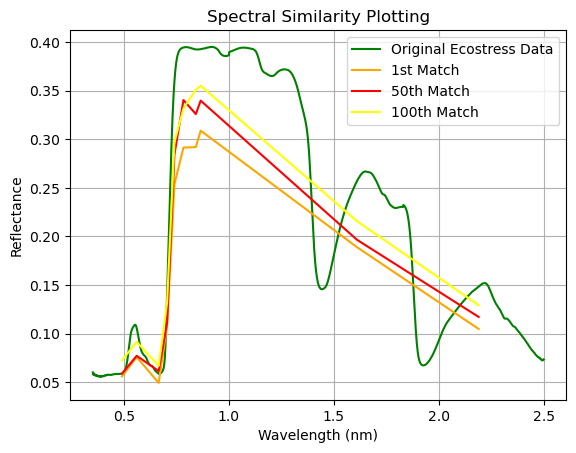

In [74]:
#Run Code to Get Spectral Angles and Plot Spectral Similarity -- Tree Data
tree_spectral_angles = calculate_all_angles(data, tree_data)

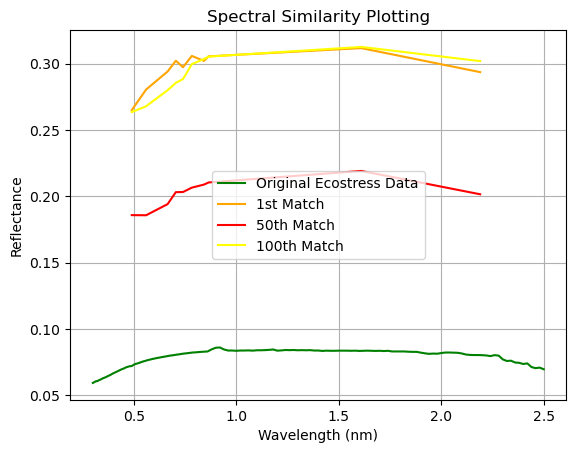

In [75]:
#Run Code to Get Spectral Angles, nd Plot Spectral Similarity -- Asphault Data
road_spectral_angles = calculate_all_angles(data, road_data)

In order to determine a cutoff angle, I plotted different cutoff angles to determine which looked the most accurate based on the Sentinel-2 Bands.

In [76]:
#Function to plot multiple cutoffs and pick the best one
def plot_multiple_cutoffs(spectral_angles, cutoffs, colorway, title):
    #Set up plots
    fig, ax = plt.subplots(nrows=1, ncols=len(cutoffs), figsize=(15, 5))
    fig.suptitle(title, y=1, fontsize=16)
    for i in range(len(cutoffs)):
        mask = spectral_angles <= cutoffs[i]
        ax[i].imshow(mask, cmap=colorway) 
        ax[i].set_title("Cutoff Angle: " + str(cutoffs[i]))
    plt.tight_layout()
    plt.show()
#Possible Cutoffs
possible_cutoffs = [10,15,20,25,30]

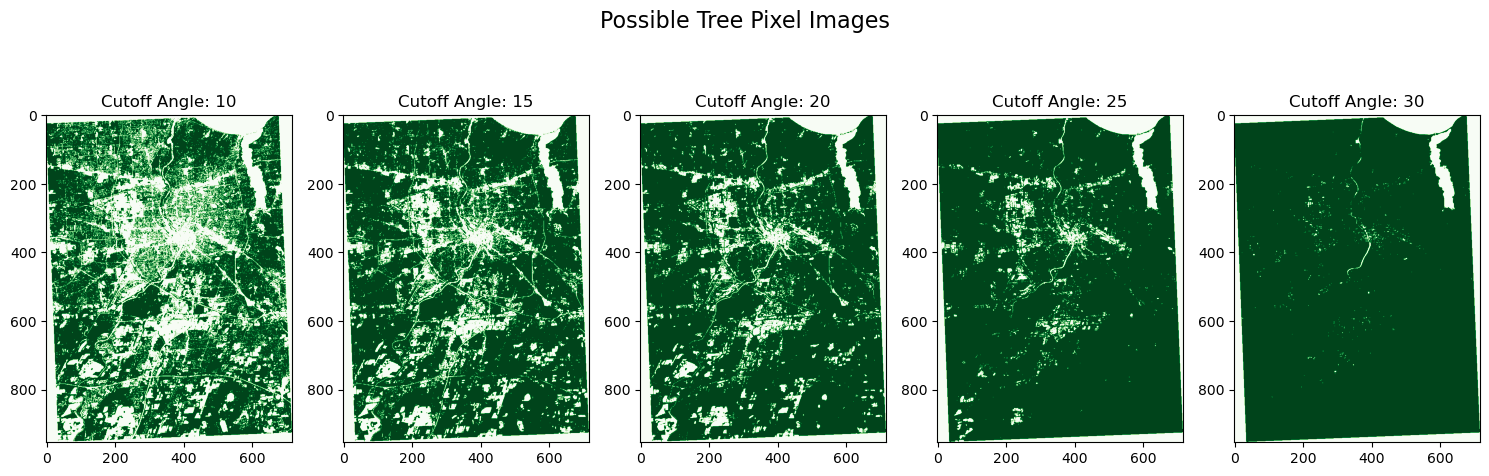

In [77]:
#Plot possible cuttoffs for trees    
plot_multiple_cutoffs(tree_spectral_angles, possible_cutoffs, "Greens", "Possible Tree Pixel Images")

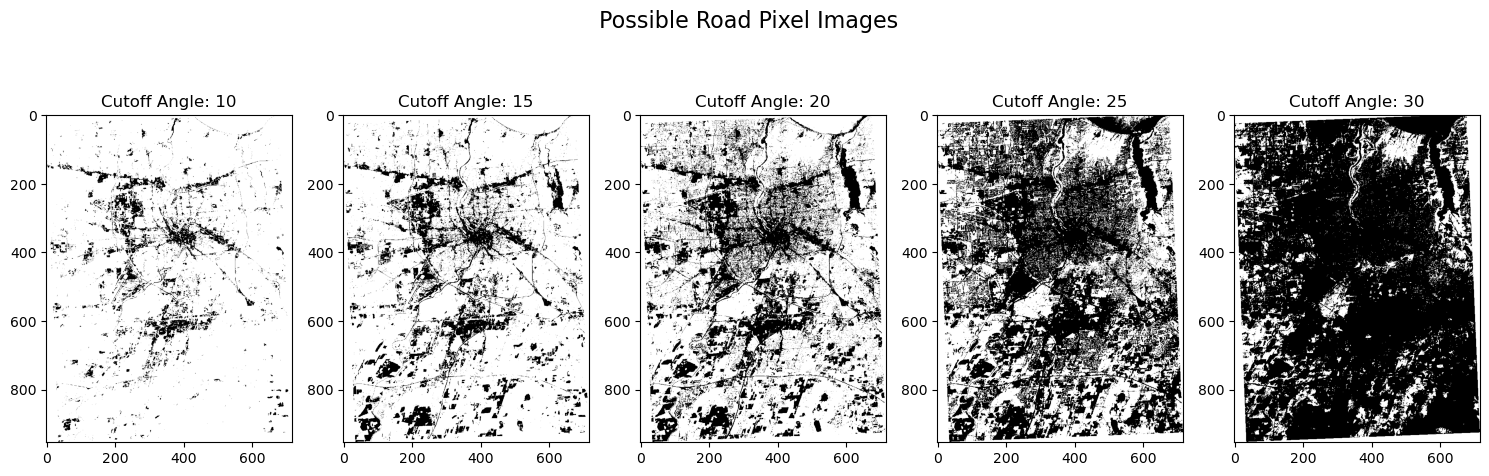

In [78]:
#Plot possible cutoffs for the road
plot_multiple_cutoffs(road_spectral_angles, possible_cutoffs, "Greys", " Possible Road Pixel Images")

For both, I thought that somewhere inbetween 10 and 15 looked best, so for my final cutoff angles, I plotted with a 12.5 degree cuttoff angle.

Text(0.5, 1.0, 'Asphalt Pixels')

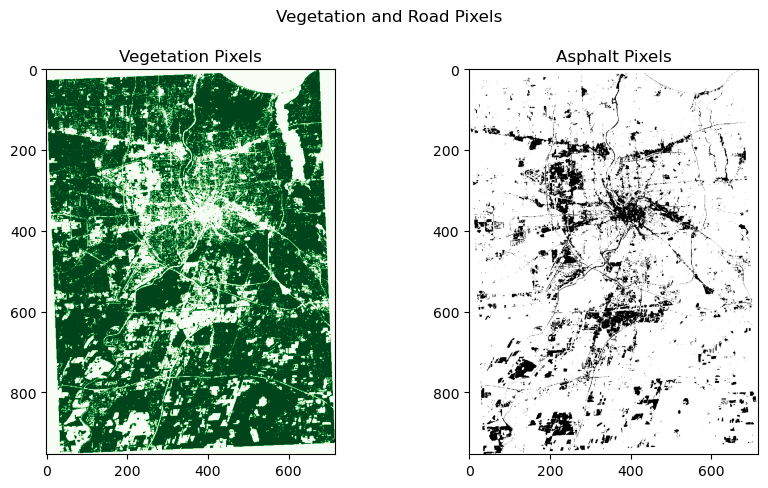

In [79]:
tree_mask = tree_spectral_angles <= 12.5
road_mask = road_spectral_angles <= 12.5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Vegetation and Road Pixels", y=1)
ax[0].imshow(tree_mask, cmap="Greens") 
ax[0].set_title("Vegetation Pixels")
ax[1].imshow(road_mask, cmap="Greys") 
ax[1].set_title("Asphalt Pixels")
